In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/
%cd cs498\ DL/Assignment4

/content/drive/My Drive
/content/drive/My Drive/cs498 DL/Assignment4


In [ ]:
!pip install Unidecode

# Generating Text with an RNN

In [ ]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [ ]:
from rnn.model import RNN
from rnn.helpers import time_since
from rnn.generate import generate

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [ ]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = './shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 4573338
train len:  4116004
test len:  457334


In [ ]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

is night to Messina.

Messenger:
He is very near by this: he was not three leagues off
when I left him.

LEONATO:
How many gentlemen have you lost in this action?

Messenger:
But few of any sort, and n


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [ ]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [ ]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [ ]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Train RNN

In [ ]:
batch_size = 100
n_epochs = 5000
hidden_size = 150
n_layers = 4
learning_rate = 0.001
model_type = 'gru'
print_every = 50
plot_every = 50


In [ ]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [ ]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    loss = 0
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    batch_size = input.shape[0]
    hidden = rnn.init_hidden(batch_size, device)
    rnn.zero_grad()

    input = input.to(device)
    target = target.to(device)

    for c in range(chunk_len):
        output, hidden = rnn(input[:, c], hidden)
        loss += criterion(output, target[:, c])

    loss.backward()
    optimizer.step()
    ##########       END      ##########

    return loss.data.item() / chunk_len


In [ ]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 45s (50 1%) train loss: 3.3300, test_loss: 3.3086]
Whdh :eo snog wr h
i:ase ee a oeessth ml wet 
it dtyto aar o 

oOres  
ah ehUt 
 ea
ioarea shth 
'isth 

 30s (100 2%) train loss: 3.2461, test_loss: 3.2649]
Whcou e  oonk
O
i  ldn  el i
ts  dn od
 tret lhi seI  huae
 iy pi 'w orfuAHn  t ho,d atw tesS ell asat 

 16s (150 3%) train loss: 2.7817, test_loss: 2.7605]
Whs uers oahe are, lhey su nrolusse od mt hsiom waanphoe oonrk on ftht yeegt ie eteunWw. uttaaht ter
N 

 2s (200 4%) train loss: 2.6196, test_loss: 2.6162]
Whtmelaie hsll! wve aosrds dentd oe ahe ere mfln'd sitill id bo, eor tlctrlet lo powrh eo to id tpaotk 

 47s (250 5%) train loss: 2.3921, test_loss: 2.4057]
Whoed het we to ool,
Worfalul celes pon tirm to to nor,
Arary to so ose'd, onluud alar.

FUOU:
Those f 

 32s (300 6%) train loss: 2.2360, test_loss: 2.2578]
Whiuns.
Bake:
For doth me pelt tharss ussend the I helt thit'mes go be lold tto pless opse as rele so  

 18s (350 7%) train loss: 

In [ ]:
# save network
torch.save(rnn.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

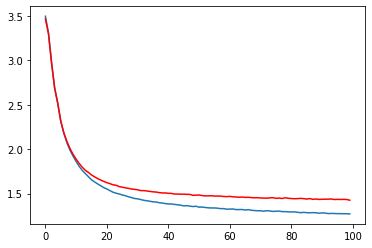

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [ ]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

Then call his party.
Oft any man I am fairest for arpent, and bear
Are pass. Now, call me to the detenty.

AEGEON:
I will not put on.

LEONATO:
Madam, combat, yet he had never can so strike him
As cheekl to a face to be forth two want.

DUKE VINCENTIO:
What wrong soon,
From the sight, that you should fly to Ford under a
You choose point, and in the sea to liminius,
And so he is none and his babe Cains:
Of heavens and made back and heart to fear
The heart of what he has spleave here as it
Which oft she presently to thine eyes.

LPAVIA:
I'll thy error to early eye on her father.

BENVOLIO:
No, the wrongs of grace that we perchance with a
she is. What says Looked poyer, I will be so, that were
the self, and Timon! may I find up your grace?

BAPTISTA:
Ay, therein by safety, and let them come
Or holy death wide-royal looks and Alic,
Farewell to the Thracious untimely virtue,
What we have, and go to the pound for with his grave
And Naence men well, and I am in Rome.

KING HENRY VIII:
Then he

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.